## Optimal Growth Temperature (OGT): phenotype prediction, feature selection, and data visualization

This notebook provides a pipeline for predicting the optimal growth temperature (OGT) and identifying genome footprints.

We train and test XGBoost regression on COG count tables, that are split into the test and train ones at a specified taxonomy level (i.e. all samples from a taxonomy group go to either train or test). The notebook can be run for one taxonomy level split.

To identify genome footprints and the most important features (COGs) contributing to the phenotype prediction, we use three different feature selection ranking methods:

- calculating the mutual information between the feature and the target label vector,
- using the feature weights returned by the random forest model,
- calculating SHAP values using the pre-trained XGBoost model.

The predictions of those three methods are compared between each other at the end of the notebook.

#### 1. Read the train and test datasets

First, we read the input files generated by *taxa_level_split.py*. The script generates 6 output files for the chosen [tax_level] of the train/test split, that are used as main inputs in this notebook. The files are the following:

- train_data_[tax_level]_tax_level : training count table,
- train_annot_[tax_level]_tax_level : training annotations,
- train_taxa_names_[tax_level]_tax_level : [tax_level] name of each training sample,

\+ 3 similar test tables. Those files should be stored in the corresponding directory for the phenotype.

In order to run the phenotype prediction pipeline in this notebook, the data directory with the input files, and [tax_level] of the train/test split should be specified below.

## Read the input data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys

from utils.utils import read_ogt_data

# SPECIFY THE DESIRED TAXONOMY SPLIT LEVEL HERE!
TAX_LEVEL = "random" # <--------------- taxonomy level for train/test split is here!!
DATA_DIRECTORY = "data_ogt" # <-------- input data directory is here!!
FEATURES = "KOs" # <------------------- data features is here!!
NUM_SPLITS_TO_READ = 10  # <----------- number of splits to read and process is here!!

RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIRECTORY = f"../data_ogt/outputs/{FEATURES}/{TAX_LEVEL}"

In [2]:
from collections import defaultdict

all_splits_dict = defaultdict(int)
for split_id in range(NUM_SPLITS_TO_READ):
    # Read train data
    data_filename_train = f"../{DATA_DIRECTORY}/input_data/{FEATURES}/{TAX_LEVEL}/train_data_{TAX_LEVEL}_tax_level_split_{split_id}"
    y_filename_train = f"../{DATA_DIRECTORY}/input_data/{FEATURES}/{TAX_LEVEL}/train_annot_{TAX_LEVEL}_tax_level_split_{split_id}"
    taxa_names_filename_train = f"../{DATA_DIRECTORY}/input_data/{FEATURES}/{TAX_LEVEL}/train_taxa_names_{TAX_LEVEL}_tax_level_split_{split_id}" if TAX_LEVEL != "random" else None
    X_train, y_train, X_column_names, taxa_group_names_train = read_ogt_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)
    
    # Read test data
    data_filename_test = f"../{DATA_DIRECTORY}/input_data/{FEATURES}/{TAX_LEVEL}/test_data_{TAX_LEVEL}_tax_level_split_{split_id}"
    y_filename_test = f"../{DATA_DIRECTORY}/input_data/{FEATURES}/{TAX_LEVEL}/test_annot_{TAX_LEVEL}_tax_level_split_{split_id}"
    taxa_names_filename_test = f"../{DATA_DIRECTORY}/input_data/{FEATURES}/{TAX_LEVEL}/test_taxa_names_{TAX_LEVEL}_tax_level_split_{split_id}" if TAX_LEVEL != "random" else None
    X_test, y_test, X_column_names, taxa_group_names_test = read_ogt_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

    curr_split_dict = defaultdict(str)
    curr_split_dict["X_train"] = X_train
    curr_split_dict["y_train"] = y_train
    curr_split_dict["taxa_group_names_train"] = taxa_group_names_train
    curr_split_dict["X_test"] = X_test
    curr_split_dict["y_test"] = y_test
    curr_split_dict["taxa_group_names_test"] = taxa_group_names_test
    curr_split_dict["feature_names"] = X_column_names

    all_splits_dict[split_id] = curr_split_dict

In [3]:
mean_train = np.mean(y_train.cpu().squeeze().numpy())
mean_test = np.mean(y_test.cpu().squeeze().numpy())

print(f"Average OGT of the train set = {mean_train}")
print(f"Average OGT of the train set = {mean_test}")

Average OGT of the train set = 34.46595001220703
Average OGT of the train set = 33.89033508300781


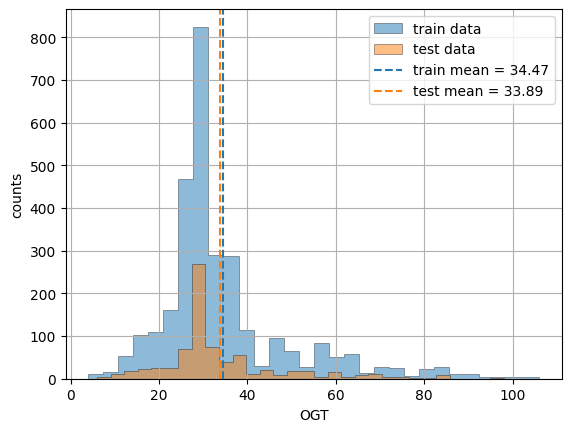

In [4]:
hist = plt.hist(y_train.cpu(), bins = 30, density = False, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:blue')
hist = plt.hist(y_test.cpu(), bins = 30, density = False, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:orange')
mean_value = y_train.cpu().mean().item()
plt.axvline(mean_value, color='tab:blue', linestyle='--', linewidth=1.5, label=f'train mean = {mean_value:.2f}')
mean_value = y_test.cpu().mean().item()
plt.axvline(mean_value, color='tab:orange', linestyle='--', linewidth=1.5, label=f'test mean = {mean_value:.2f}')


plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

#### 2. PCA and tSNE projections of the training data (colors = temperature)

In this section, we visualize all points from our datasets by projecting them into 2D PCA, and tSNE spaces. This projections give us insights on the structure of the datasets. 

First, we visualize the points and color them with respect to their OGTs.

In [5]:
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

In [6]:
# Concatenate train and test for the 2D visualization
y_label = torch.cat((y_train, y_test), dim=0)
X_val = torch.cat((X_train, X_test), dim=0)
if TAX_LEVEL != "random":
    taxa_group_names = taxa_group_names_train + taxa_group_names_test

Shape of the projected data = (3752, 2)


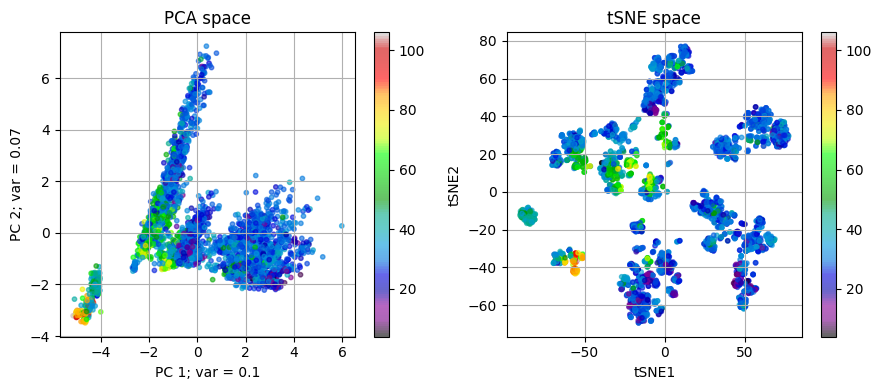

In [9]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
colorbar = True

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_val.cpu(), n_compon, y_label.cpu(), None, None, False, colorbar);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val.cpu(), 50, 100, RANDOM_SEED, y_label.cpu(), None, colorbar);


# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_orig_phenot.pdf", format="pdf")
plt.show()

In [91]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

if TAX_LEVEL != "random":
    plt.figure(figsize=(9, 4))
    
    # PCA space
    plt.subplot(1, 2, 1) 
    n_compon = 10
    colors = None
    category_names = taxa_group_names_train
    pca_run_and_plot(X_train, n_compon, label_encoder.fit_transform(category_names),
                     category_names, colors);
    # t-SNE space
    plt.subplot(1, 2, 2) 
    tsne_plot(X_train, 50, 100, RANDOM_SEED, label_encoder.fit_transform(category_names));
    
    # Display the plots
    plt.tight_layout()  
    plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_all_feat.pdf", format="pdf")
    plt.show()

## Initial prediction

In [10]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import mean_squared_error,r2_score
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05)

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test, model  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=None, model=model) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


XGBoost baseline test RMSE (all features) = 5.65, R2 = 0.83
XGBoost baseline CV RMSE (all features) = 5.92, R2 = 0.85


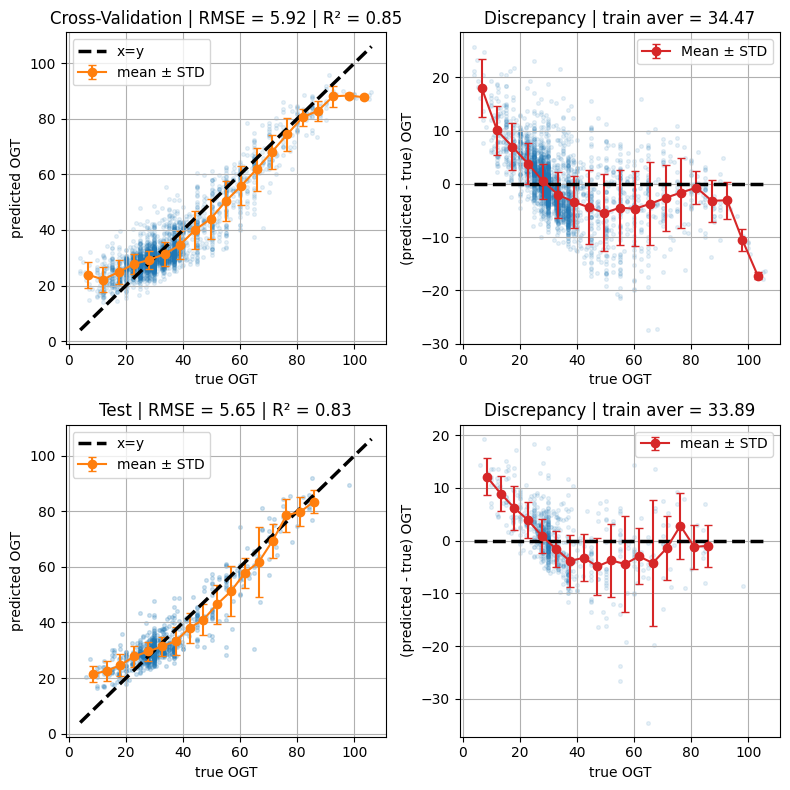

In [11]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers_cv_old, mean_diff_cv_old, std_diff_cv_old = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers_cv_old, mean_diff_cv_old, yerr=std_diff_cv_old, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers_test_old, mean_diff_test_old, std_diff_test_old = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers_test_old, mean_diff_test_old, yerr=std_diff_test_old, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

## Step 2: Train Models on Data Segments

In [12]:
# Flatten y_train to 1D
y_train_flat = y_train.cpu().flatten()

# Compute quantiles from the flattened version
low_q = 20#np.quantile(y_train_flat, 1/3)
high_q = 45#np.quantile(y_train_flat, 2/3)
print(f"low_q = {low_q}; high_q = {high_q}")

# Define masks (all 1D)
low_mask  = y_train_flat < low_q
mid_mask  = (y_train_flat >= low_q) & (y_train_flat < high_q)
high_mask = y_train_flat >= high_q

# Apply masks correctly
X_low, y_low   = X_train[low_mask].cpu(), y_train_flat[low_mask].cpu()
X_mid, y_mid   = X_train[mid_mask].cpu(), y_train_flat[mid_mask].cpu()
X_high, y_high = X_train[high_mask].cpu(), y_train_flat[high_mask].cpu()



# Optionally: split y_test the same way as y_train
y_test_flat = y_test.flatten()

low_mask_test  = y_test_flat < low_q
mid_mask_test  = (y_test_flat >= low_q) & (y_test_flat < high_q)
high_mask_test = y_test_flat >= high_q

# Test splits
X_test_low, y_test_low   = X_test[low_mask_test].cpu(), y_test_flat[low_mask_test].cpu()
X_test_mid, y_test_mid   = X_test[mid_mask_test].cpu(), y_test_flat[mid_mask_test].cpu()
X_test_high, y_test_high = X_test[high_mask_test].cpu(), y_test_flat[high_mask_test].cpu()


low_q = 20; high_q = 45


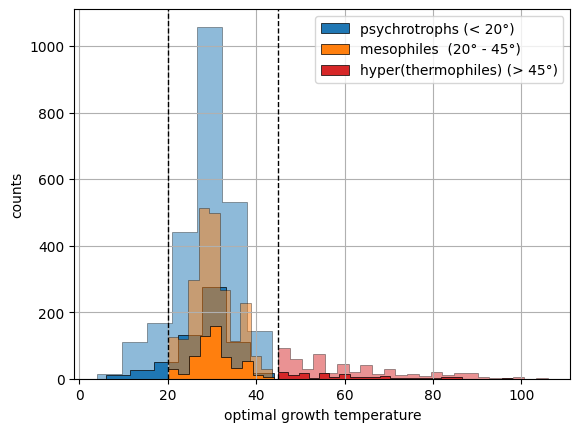

num low = 2466; num mid = 2256; num high = 536;


In [36]:
#plt.figure(figsize=(5, 3))

plt.hist(y_low, bins=7, alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:blue')
plt.hist(y_test_low, bins=7, label = "psychrotrophs (< 20°)", alpha = 1, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:blue')
plt.hist(y_mid, bins=10, alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:orange')
plt.hist(y_test_mid, bins=10, label = "mesophiles  (20° - 45°)", alpha = 1, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:orange')
plt.hist(y_high, bins=23, alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:red')
plt.hist(y_test_high, bins=23, label = "hyper(thermophiles) (> 45°)", alpha = 1, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:red')
plt.axvline(20, color='black', linestyle='--', linewidth=1)
plt.axvline(45, color='black', linestyle='--', linewidth=1)

plt.grid(True)

plt.xlabel("optimal growth temperature")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

plt.savefig(f"{OUTPUT_DIRECTORY}/three_sample_classes.pdf", format="pdf")
plt.show()

print(f"num low = {len(y_low)}; num mid = {len(y_mid)}; num high = {len(y_high)};")

Shape of the projected data = (3752, 2)


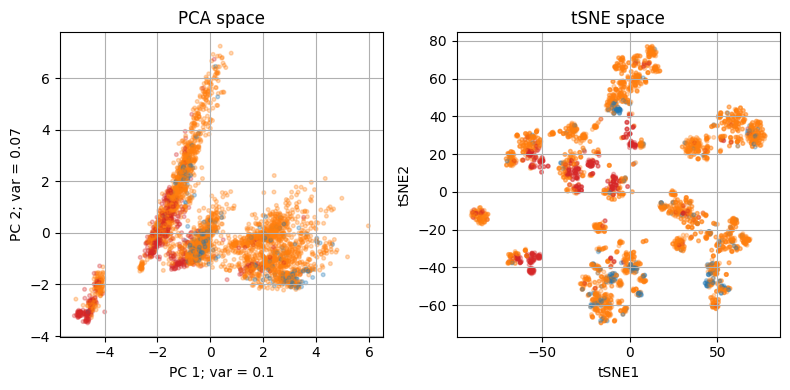

In [37]:
from utils.utils import pca_run_and_plot, tsne_plot
from matplotlib.colors import ListedColormap

y_train_masked = [2 if yi > 45 else (0 if yi < 20 else 1) for yi in y_label.cpu()]

colors = ListedColormap(["tab:blue", "tab:orange", "tab:red"])

plt.figure(figsize=(8, 4))
colorbar = False

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_val.cpu(), n_compon, y_train_masked, None, colors, False, colorbar, alpha=0.3, s = 7);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val.cpu(), 50, 100, RANDOM_SEED, y_train_masked, colors, colorbar, alpha=0.3, s = 7);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_three_temp_ranges.pdf", format="pdf")
plt.show()

In [38]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

#model = XGBRegressor(reg_alpha=1.0,reg_lambda=1.0, max_depth=3,subsample=0.8, colsample_bytree=0.8, n_estimators=300,learning_rate=0.05)
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05)

model_low  = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_low, y_low)
model_mid  =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_mid, y_mid)
model_high =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_high, y_high)

In [39]:
def evaluate_model(model, X_test, y_test, segment_name):
    preds = model.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)

    print(f"\nPerformance on {segment_name} segment:")
    print(f"  R²   : {r2:.3f}")
    print(f"  MAE  : {mae:.3f}")
    print(f"  RMSE : {rmse:.3f}")
    return r2, mae, rmse

In [40]:
# Evaluate each model
evaluate_model(model_low,  X_test_low.cpu(),  y_test_low.cpu(),  "Low")
evaluate_model(model_mid,  X_test_mid.cpu(),  y_test_mid.cpu(),  "Mid")
evaluate_model(model_high, X_test_high.cpu(), y_test_high.cpu(), "High")


Performance on Low segment:
  R²   : 0.469
  MAE  : 3.381
  RMSE : 4.528

Performance on Mid segment:
  R²   : 0.256
  MAE  : 2.955
  RMSE : 3.865

Performance on High segment:
  R²   : 0.805
  MAE  : 4.147
  RMSE : 5.257


C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.8048248291015625, 4.1468844, 5.2569995)

In [41]:
gain_dict = model_low.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_low)
print(f"Tot gain in low model = {total_gain}")

gain_dict = model_mid.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_mid)
print(f"Tot gain in mid model = {total_gain}")

gain_dict = model_high.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_high)
print(f"Tot gain in high model = {total_gain}")

Tot gain in low model = 86.95584681352173
Tot gain in mid model = 53.31187705642788
Tot gain in high model = 201.58511159924873


### Test Generalization Between Segments

In [42]:
preds = model_low.predict(X_mid)
preds_test = model_low.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
r2_test

0.2838175296783447

In [43]:
model_mid  =  XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.05).fit(X_mid, y_mid)

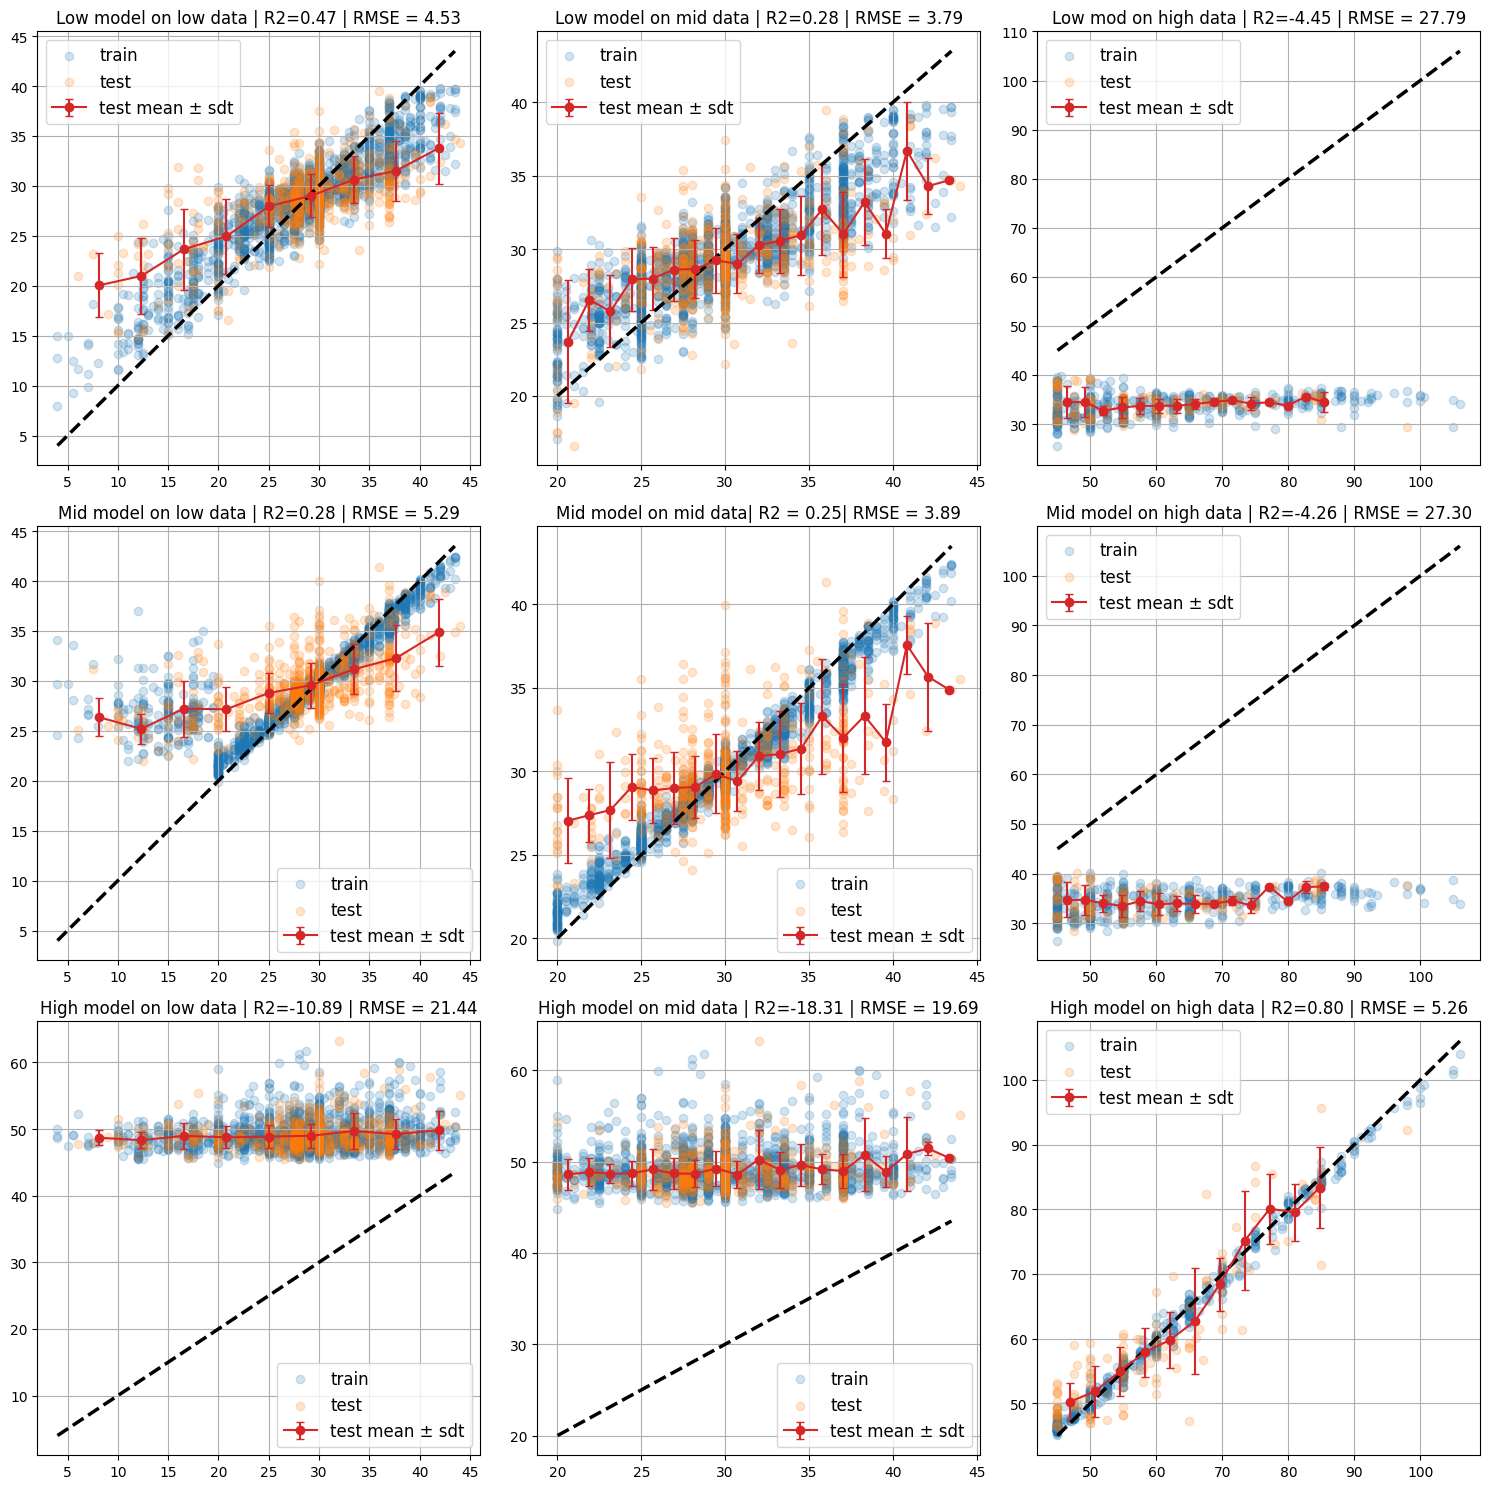

In [44]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 3, 1) 
preds = model_low.predict(X_low)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
preds_test = model_low.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test =  r2_score(y_test_low, preds_test)
plt.scatter(y_test_low.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± sdt')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)

plt.subplot(3, 3, 2) 
preds = model_low.predict(X_mid)
preds_test = model_low.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± sdt')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)


plt.subplot(3, 3, 3) 
preds = model_low.predict(X_high)
preds_test = model_low.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, preds_test))
r2_test = r2_score(y_test_high, preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model_low.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_high.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± sdt')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low mod on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)


plt.subplot(3, 3, 4) 
preds = model_mid.predict(X_low)
preds_test = model_mid.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test = r2_score(y_test_low, preds_test)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_low.flatten(), model_mid.predict(X_test_low), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± sdt')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)


plt.subplot(3, 3, 5) 
preds = model_mid.predict(X_mid)
preds_test = model_mid.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test = r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), model_mid.predict(X_test_mid), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± sdt')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on mid data| R2 = {r2_test:.2f}| RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)


plt.subplot(3, 3, 6) 
preds = model_mid.predict(X_high)
preds_test = model_mid.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, preds_test))
r2_test = r2_score(y_test_high, preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model_mid.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_high.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± sdt')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)


plt.subplot(3, 3, 7) 
preds = model_high.predict(X_low)
preds_test = model_high.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test = r2_score(y_test_low, preds_test)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_low.flatten(), model_high.predict(X_test_low), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± sdt')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)


plt.subplot(3, 3, 8) 
preds = model_high.predict(X_mid)
preds_test = model_high.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test = r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), model_high.predict(X_test_mid), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± sdt')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)


plt.subplot(3, 3, 9) 
preds = model_high.predict(X_high)
preds_test = model_high.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high.flatten(), preds_test))
r2_test = r2_score(y_test_high.flatten(), preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model_high.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers_l, mean_diff_l, std_diff_l = calculate_aver_std(y_test_high.flatten(), preds_test, 15)
plt.errorbar(bin_centers_l, mean_diff_l, yerr=std_diff_l, fmt='o-', color='tab:red', capsize=3, label='test mean ± sdt')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)

plt.savefig(f"{OUTPUT_DIRECTORY}/three_models_perform.pdf", format="pdf")

plt.tight_layout()

In [508]:
model = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())


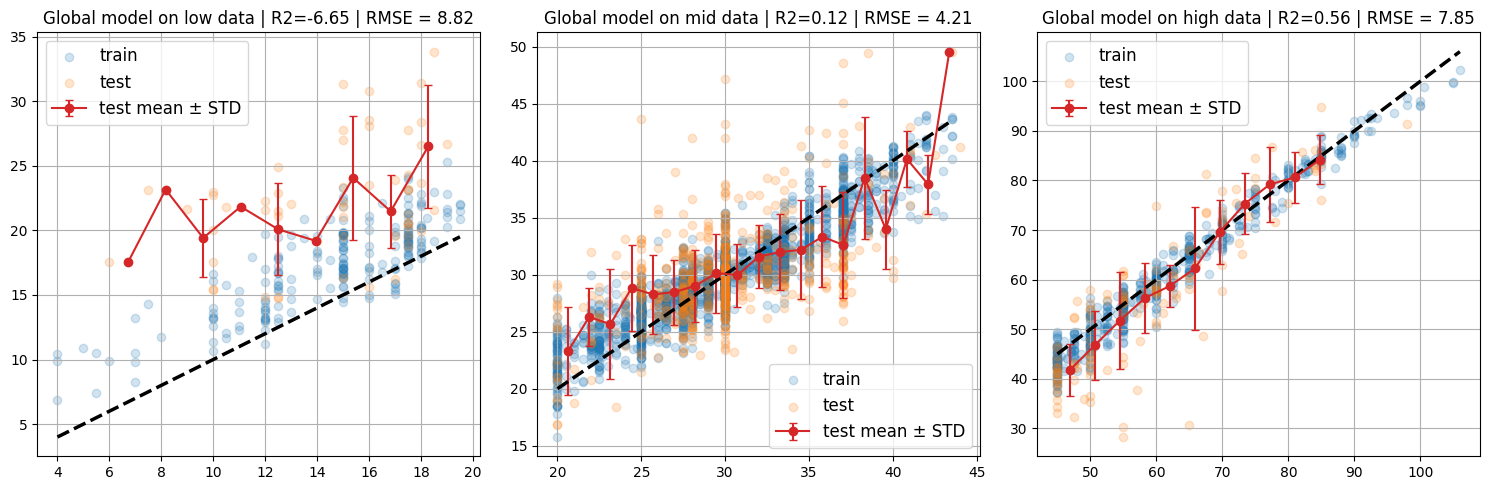

In [509]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1) 
preds = model.predict(X_low)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
preds_test = model.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test =  r2_score(y_test_low, preds_test)
plt.scatter(y_test_low.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Global model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)

plt.subplot(1, 3, 2) 
preds = model.predict(X_mid)
preds_test = model.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Global model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)


plt.subplot(1, 3, 3) 
preds = model.predict(X_high)
preds_test = model.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, preds_test))
r2_test = r2_score(y_test_high, preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers_ll, mean_diff_ll, std_diff_ll = calculate_aver_std(y_test_high.flatten(), preds_test, 15)
plt.errorbar(bin_centers_ll, mean_diff_ll, yerr=std_diff_ll, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Global model on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend(fontsize=12)
plt.grid(True)

plt.savefig(f"{OUTPUT_DIRECTORY}/general_model_perform.pdf", format="pdf")

plt.tight_layout()

In [510]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_train)


# Define masks (all 1D)
low_mask  = y_train_flat < low_q
mid_mask  = (y_train_flat >= low_q) & (y_train_flat < high_q)
high_mask = y_train_flat >= high_q

strength_low = np.abs(shap_values.values[low_mask]).sum(axis=1).mean()
strength_mid = np.abs(shap_values.values[mid_mask]).sum(axis=1).mean()
strength_high = np.abs(shap_values.values[high_mask]).sum(axis=1).mean()

print(f"Low strength: {strength_low}")
print(f"Mid strength: {strength_mid}")
print(f"High strength: {strength_high}")

Low strength: 29.99656867980957
Mid strength: 26.350017547607422
High strength: 46.12675476074219


In [511]:
import shap
explainer = shap.Explainer(model_low)
shap_values = explainer(X_low)

strength_low_on_low = np.abs(shap_values.values).sum(axis=1).mean()

print(f"Low on low strength: {strength_low_on_low}")

Low on low strength: 6.096555709838867


In [512]:
explainer = shap.Explainer(model_mid)
shap_values = explainer(X_mid)

strength_mid_on_mid = np.abs(shap_values.values).sum(axis=1).mean()

print(f"Mid on midw strength: {strength_mid_on_mid}")

Mid on midw strength: 11.836041450500488


In [513]:
explainer = shap.Explainer(model_high)
shap_values = explainer(X_high)

strength_high_on_high = np.abs(shap_values.values).sum(axis=1).mean()

print(f"High on high strength: {strength_high_on_high}")

High on high strength: 24.095624923706055


### Top important features

In [23]:
# Get feature importance scores (by gain)
gain_dict = model_low.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the low model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")


Top 10 most important features by gain in the low model:
K01589: 174.52
K04566: 101.44
K07341: 100.17
K03750: 83.83
K00790: 79.54
K01996: 78.40
K01712: 75.58
K00606: 72.36
K09780: 70.53
K02663: 64.38


In [24]:
# Get feature importance scores (by gain)
gain_dict = model_mid.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the mid model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")


Top 10 most important features by gain in the mid model:
K00164: 1512.19
K06970: 393.89
K06113: 368.89
K07137: 332.33
K02227: 331.22
K01808: 270.50
K03807: 263.12
K13255: 258.88
K01785: 245.83
K15654: 218.21


In [25]:
# Get feature importance scores (by gain)
gain_dict = model_high.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the high model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")


Top 10 most important features by gain in the high model:
K03170: 8538.89
K09128: 4052.80
K06951: 1947.28
K18682: 1802.25
K02357: 1417.01
K07007: 1087.19
K01934: 1023.81
K06881: 990.21
K00537: 913.17
K01066: 889.77


### Vizualization 

Shape of the projected data = (913, 2)


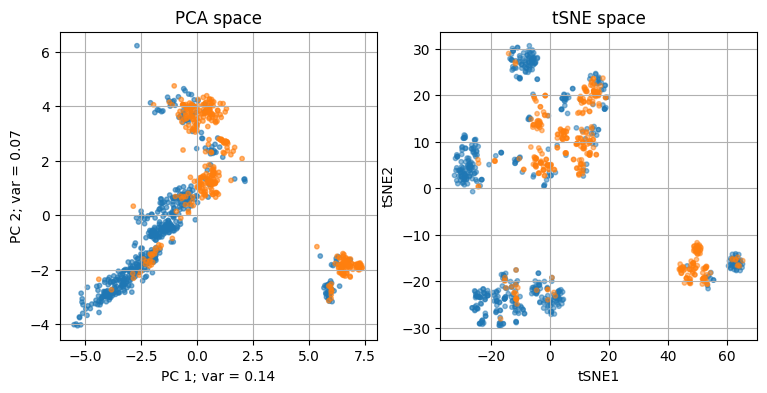

In [26]:
from utils.utils import pca_run_and_plot, tsne_plot
from matplotlib.colors import ListedColormap

y_train_masked = [5 if yi>45  else 0 for yi in y_train]

colors = ListedColormap(["tab:blue", "tab:orange"])
plt.figure(figsize=(9, 4))
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train, n_compon, y_train_masked, None, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, 50, 100, RANDOM_SEED, y_train_masked, colors);

Shape of the projected data = (913, 2)


Text(0.5, 0.98, 'Expression level of K03170')

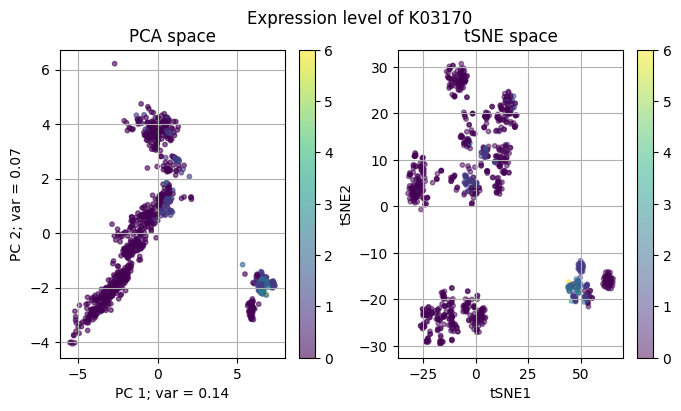

In [27]:
feature_name = 'K03170'
X_column_names = list(X_column_names)

if feature_name in X_column_names:
    idx = X_column_names.index(feature_name)
else:
    print(f"This feature doesn't exist in the feature space!")

feature_expression = X_train[:, idx]
feature_expression = feature_expression.cpu()

from matplotlib import cm
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colorbar = True
colors = ListedColormap(cm.viridis(np.linspace(0, 1, len(feature_expression))))
pca_run_and_plot(X_train.cpu(), n_compon, feature_expression, None, colors, legend = False, colorbar = colorbar);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train.cpu(), 50, 100, RANDOM_SEED, feature_expression, colors, colorbar = colorbar);
plt.suptitle(f"Expression level of {feature_name}")

### Mixture of experts model

In [514]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# --- 1. Label each sample as low, mid, or high OGT group
def label_ogt_range(y, low_thresh=20, high_thresh=45):
    labels = []
    for val in y:
        if val < low_thresh:
            labels.append('low')
        elif val <= high_thresh:
            labels.append('mid')
        else:
            labels.append('high')
    return np.array(labels)

# Assign labels
range_labels = label_ogt_range(y_train)

le = LabelEncoder()
range_ids = le.fit_transform(range_labels)  # Converts to 0,1,2

label_to_int = {'low': 0, 'mid': 1, 'high': 2}

# Vectorized conversion
range_ids = np.vectorize(label_to_int.get)(range_labels)

range_labels_test = label_ogt_range(y_test)
range_ids_test = np.vectorize(label_to_int.get)(range_labels_test)

(array([ 56., 583., 111.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

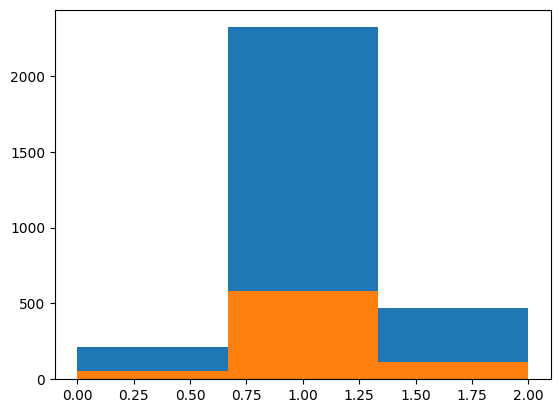

In [515]:
plt.hist(range_ids, bins=3)
plt.hist(range_ids_test, bins=3)

In [516]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
classes = np.unique(range_ids)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=range_ids)
weights = [7, 0.1, 4]

#weights = [1, 1, 1]

# Convert to dictionary format for xgboost
class_weights = dict(zip(classes, weights))

#class_weights[1]=0.01

# Pass weights to each sample
sample_weights = np.array([class_weights[c] for c in range_ids])

class_weights

{0: 7, 1: 0.1, 2: 4}

In [517]:
label_to_int = {'low': 0, 'mid': 1, 'high': 2}

# Vectorized conversion
range_ids = np.vectorize(label_to_int.get)(range_labels)


In [518]:
def xgboost_mixture_of_experts_3_class(X_train, y_train, range_ids, sample_weights, X_test):
    num_classes = 3
    gating_model = XGBClassifier(
        n_jobs=-1,
        tree_method="hist",
        objective="multi:softmax",   # Multi-class classification
        num_class=num_classes,       # Number of target classes
        eval_metric="mlogloss",      # Suitable for multi-class
    )
    
    gating_model.fit(X_train.cpu(), range_ids, sample_weight=sample_weights )  # Predicts soft assignments to experts
    
    
    # --- 4. Get gating probabilities (soft weights for each expert)
    gate_probs = gating_model.predict_proba(X_test.cpu())  # Shape: (n_samples, 3)
    gate_preds = gating_model.predict(X_test.cpu()) 

    # Flatten y_train to 1D
    y_train_flat = y_train.cpu().flatten()

    low_q = 20
    high_q = 45
    
    # Define masks (all 1D)
    low_mask  = y_train_flat < low_q
    mid_mask  = (y_train_flat >= low_q) & (y_train_flat < high_q)
    high_mask = y_train_flat >= high_q
    
    # Apply masks correctly
    X_low, y_low   = X_train[low_mask].cpu(), y_train_flat[low_mask].cpu()
    X_mid, y_mid   = X_train[mid_mask].cpu(), y_train_flat[mid_mask].cpu()
    X_high, y_high = X_train[high_mask].cpu(), y_train_flat[high_mask].cpu()
    
    model_low  = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_low, y_low)
    model_mid  =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_mid, y_mid)
    model_high =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_high, y_high)
    
    # --- 3. Get expert predictions for all samples
    pred_low  = model_low.predict(X_test)
    pred_mid  = model_mid.predict(X_test)
    pred_high = model_high.predict(X_test)
    

    final_pred = (
        gate_probs[:, 0]  * pred_low +
        gate_probs[:, 1]  * pred_mid +
        gate_probs[:, 2] * pred_high
    )

    return gating_model, gate_probs, final_pred
    
    # # --- 6. Evaluate
    # rmse = mean_squared_error(y_test.cpu(), final_pred, squared=False)
    # print(f"Final Mixture-of-Experts RMSE: {rmse:.2f}")

In [519]:
gating_model, gate_probs, final_pred = xgboost_mixture_of_experts_3_class(X_train, y_train, range_ids, sample_weights, X_test)

In [520]:
sample_weights

array([0.1, 0.1, 0.1, ..., 0.1, 4. , 0.1])

              precision    recall  f1-score   support

           0       0.72      0.52      0.60        56
           1       0.93      0.96      0.95       583
           2       0.89      0.87      0.88       111

    accuracy                           0.91       750
   macro avg       0.85      0.78      0.81       750
weighted avg       0.91      0.91      0.91       750



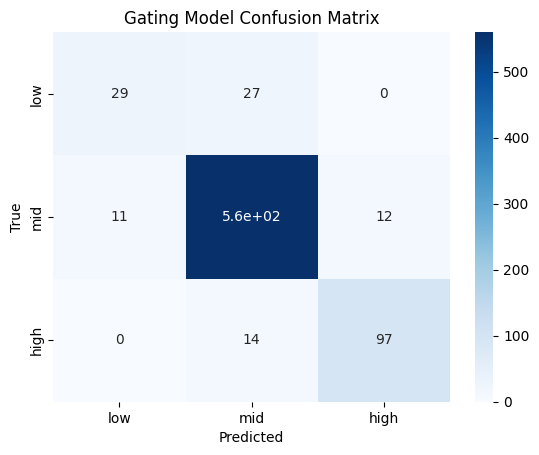

In [521]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

gate_preds = gating_model.predict(X_test.cpu()) 
print(classification_report(range_ids_test,gate_preds))

cm = confusion_matrix(range_ids_test, gate_preds)

sns.heatmap(cm, annot=True, xticklabels=["low", "mid", "high"], yticklabels=["low", "mid", "high"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Gating Model Confusion Matrix")
plt.show()

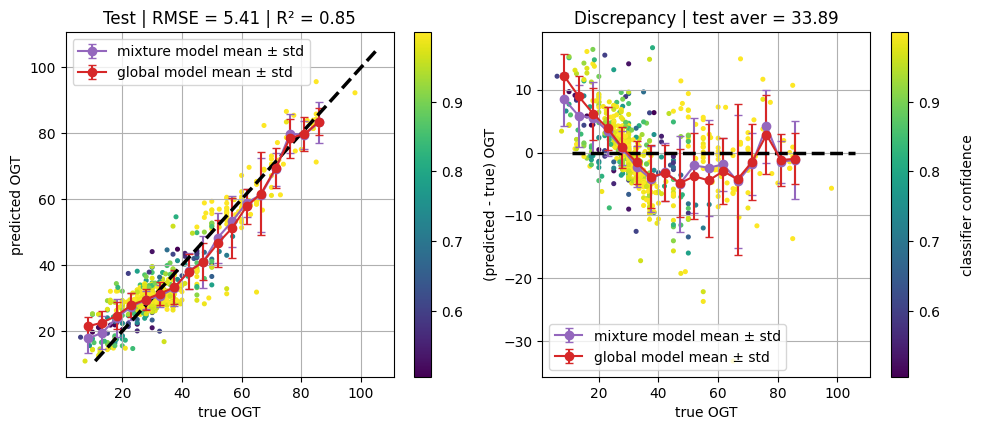

In [522]:
from utils.utils import train_xgboost, calculate_aver_std

plt.figure(figsize=(10, 8))

y_test = y_test.cpu()
mx_prob = [max(g) for g in gate_probs]

num_bins = 20
min_temp = min(final_pred.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_test.cpu(), final_pred, marker='o', alpha = 1, c = mx_prob, s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), final_pred, num_bins)
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze(), final_pred))
r2_test = r2_score(y_test.squeeze(), final_pred)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:purple', capsize=3, label='mixture model mean ± std')
plt.errorbar(bin_centers_cv_old, mean_diff_cv_old, yerr=std_diff_cv_old, fmt='o-', color='tab:red', capsize=3, label='global model mean ± std')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.legend()
plt.grid(True)
cbar = plt.colorbar()

# Diff for full signal  
plt.subplot(2, 2, 2) 
y_test = y_test.cpu()
diff = [final_pred[i] - y_test[i] for i in range(len(final_pred))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 1, c = mx_prob, s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:purple', capsize=3, label='mixture model mean ± std')
plt.errorbar(bin_centers_test_old, mean_diff_test_old, yerr=std_diff_test_old, fmt='o-', color='tab:red', capsize=3, label='global model mean ± std')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | test aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label("classifier confidence", rotation=90, labelpad=15)  # vertical title



# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/mixture_of_experts_3_class.pdf", format="pdf")
plt.show()

Top 20 important features:
K07146: 0.1195
K03706: 0.0684
K06416: 0.0482
K06158: 0.0475
K00799: 0.0310
K06306: 0.0203
K00282: 0.0193
K03648: 0.0146
K01815: 0.0127
K17278: 0.0109
K06390: 0.0105
K11530: 0.0087
K00227: 0.0080
K19139: 0.0069
K07464: 0.0065
K02806: 0.0062
K00574: 0.0059
K07223: 0.0058
K03043: 0.0055
K19687: 0.0053


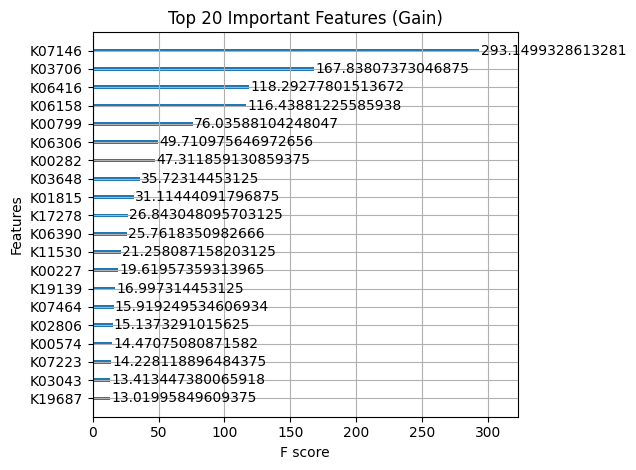

In [467]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importances from trained model
importances = gating_model.feature_importances_

# Use your actual column names
feature_names = X_column_names  # Make sure it's a list of strings

# Pair and sort
feature_importance_list = sorted(zip(feature_names, importances), key=lambda x: -x[1])

# Print top features
print("Top 20 important features:")
for feature, score in feature_importance_list[:20]:
    print(f"{feature}: {score:.4f}")

booster = gating_model.get_booster()

# Assign actual feature names
booster.feature_names = list(X_column_names)

# Plot
xgb.plot_importance(gating_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Important Features (Gain)")
plt.tight_layout()
plt.show()


### Two class modelling

In [45]:
# Flatten y_train to 1D
y_train_flat = y_train.cpu().flatten()

# Compute quantiles from the flattened version
low_q = 45

# Define masks (all 1D)
low_mask  = y_train_flat < low_q
high_mask = y_train_flat >= low_q

# Apply masks correctly
X_low, y_low   = X_train[low_mask].cpu(), y_train_flat[low_mask].cpu()
X_high, y_high = X_train[high_mask].cpu(), y_train_flat[high_mask].cpu()



# Optionally: split y_test the same way as y_train
y_test_flat = y_test.flatten()

low_mask_test  = y_test_flat < low_q
high_mask_test = y_test_flat >= low_q

# Test splits
X_test_low, y_test_low   = X_test[low_mask_test].cpu(), y_test_flat[low_mask_test].cpu()
X_test_high, y_test_high = X_test[high_mask_test].cpu(), y_test_flat[high_mask_test].cpu()

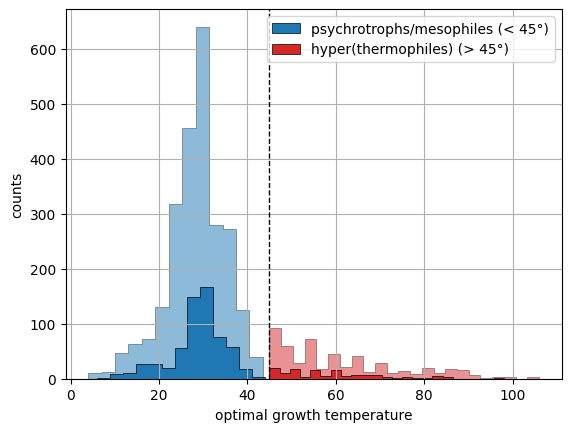

num low = 2466; num mid = 2256; num high = 536;


In [46]:
#plt.figure(figsize=(5, 3))

plt.hist(y_low, bins=13, alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:blue')
plt.hist(y_test_low, bins=13, label = "psychrotrophs/mesophiles (< 45°)", alpha = 1, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:blue')
plt.hist(y_high, bins=23, alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:red')
plt.hist(y_test_high, bins=23, label = "hyper(thermophiles) (> 45°)", alpha = 1, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:red')
plt.axvline(45, color='black', linestyle='--', linewidth=1)

plt.grid(True)

plt.xlabel("optimal growth temperature")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

plt.savefig(f"{OUTPUT_DIRECTORY}/two_sample_classes.pdf", format="pdf")
plt.show()

print(f"num low = {len(y_low)}; num mid = {len(y_mid)}; num high = {len(y_high)};")

Shape of the projected data = (3752, 2)


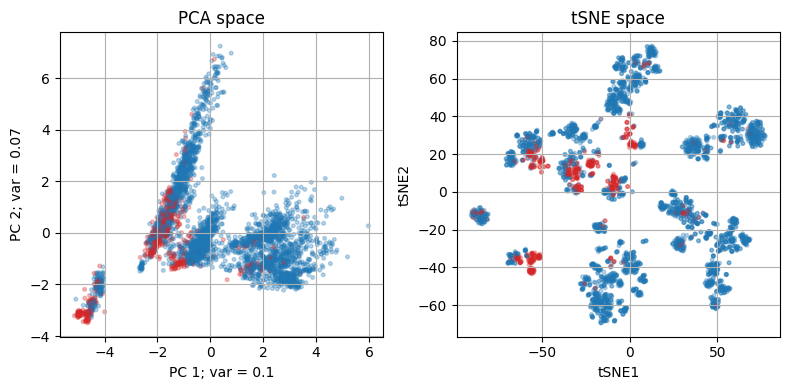

In [47]:
from utils.utils import pca_run_and_plot, tsne_plot
from matplotlib.colors import ListedColormap

y_train_masked = [1 if yi > 45 else 0 for yi in y_label.cpu()]

colors = ListedColormap(["tab:blue", "tab:red"])

plt.figure(figsize=(8, 4))
colorbar = False

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_val.cpu(), n_compon, y_train_masked, None, colors, False, colorbar, alpha=0.3, s = 7);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val.cpu(), 50, 100, RANDOM_SEED, y_train_masked, colors, colorbar, alpha=0.3, s = 7);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_two_temp_ranges.pdf", format="pdf")
plt.show()

In [48]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


# --- 1. Label each sample as low, mid, or high OGT group
def label_ogt_range(y,high_thresh=45):
    labels = []
    for val in y:
        if val < high_thresh:
            labels.append('low')
        else:
            labels.append('high')
    return np.array(labels)

# Assign labels
range_labels = label_ogt_range(y_train)

le = LabelEncoder()
range_ids = le.fit_transform(range_labels)  # Converts to 0,1,2

label_to_int = {'low': 0, 'high': 1}

# Vectorized conversion
range_ids = np.vectorize(label_to_int.get)(range_labels)

range_labels_test = label_ogt_range(y_test)
range_ids_test = np.vectorize(label_to_int.get)(range_labels_test)

(array([620., 130.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

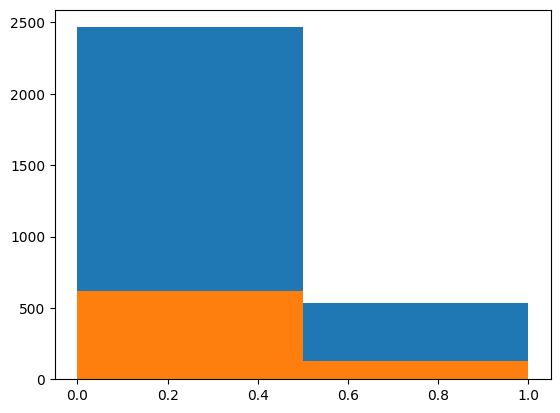

In [49]:
plt.hist(range_ids, bins=2)
plt.hist(range_ids_test, bins=2)

In [50]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
classes = np.unique(range_ids)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=range_ids)

# Convert to dictionary format for xgboost
class_weights = dict(zip(classes, weights))

class_weights[0]=1
class_weights[1]=10

# Pass weights to each sample
sample_weights = np.array([class_weights[c] for c in range_ids])

class_weights

{0: 1, 1: 10}

In [51]:
def xgboost_mixture_of_experts_2_class(X_train, y_train, range_ids, sample_weights, X_test):

    num_classes = 2
    temp_bound = 45
    gating_model = XGBClassifier(
        n_jobs=-1,
        tree_method="hist",
        objective="binary:logistic",   # Binary classification objective
        eval_metric="logloss",         # Suitable for binary classification
    )

    gating_model.fit(X_train.cpu(), range_ids,sample_weight=sample_weights )  # Predicts soft assignments to experts

    # --- 4. Get gating probabilities (soft weights for each expert)
    gate_probs = gating_model.predict_proba(X_test.cpu())  # Shape: (n_samples, 3)
    gate_preds = gating_model.predict(X_test.cpu()) 

    y_train = y_train.squeeze()

    # Define masks (all 1D)
    low_mask  = y_train < temp_bound
    high_mask = y_train >= temp_bound

    # Apply masks correctly
    X_low, y_low   = X_train[low_mask].cpu(), y_train[low_mask].cpu()
    X_high, y_high = X_train[high_mask].cpu(), y_train[high_mask].cpu()

    model_low  = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_low, y_low)
    model_high =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_high, y_high)

    pred_low  = model_low.predict(X_test)
    pred_high = model_high.predict(X_test)

    final_pred = (
        gate_probs[:, 0]  * pred_low +
        gate_probs[:, 1] * pred_high
    )

    return gating_model, gate_probs, final_pred

In [52]:
gating_model, gate_probs, final_pred = xgboost_mixture_of_experts_2_class(X_train, y_train, range_ids, sample_weights, X_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       620
           1       0.92      0.84      0.88       130

    accuracy                           0.96       750
   macro avg       0.94      0.91      0.93       750
weighted avg       0.96      0.96      0.96       750



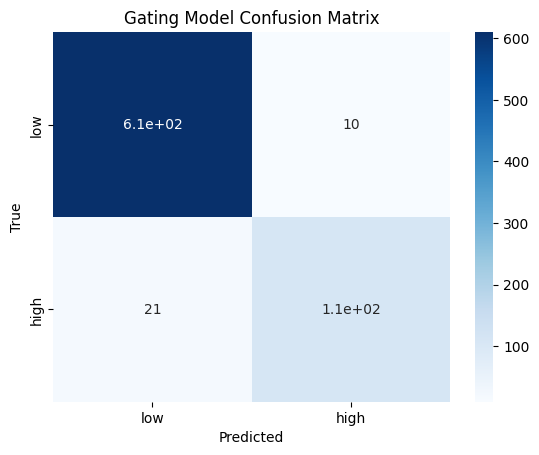

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

gate_preds = gating_model.predict(X_test.cpu()) 

print(classification_report(range_ids_test,gate_preds))

# Confusion matrix
cm = confusion_matrix(range_ids_test, gate_preds)

sns.heatmap(cm, annot=True, xticklabels=["low", "high"], yticklabels=["low", "high"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Gating Model Confusion Matrix")
plt.show()

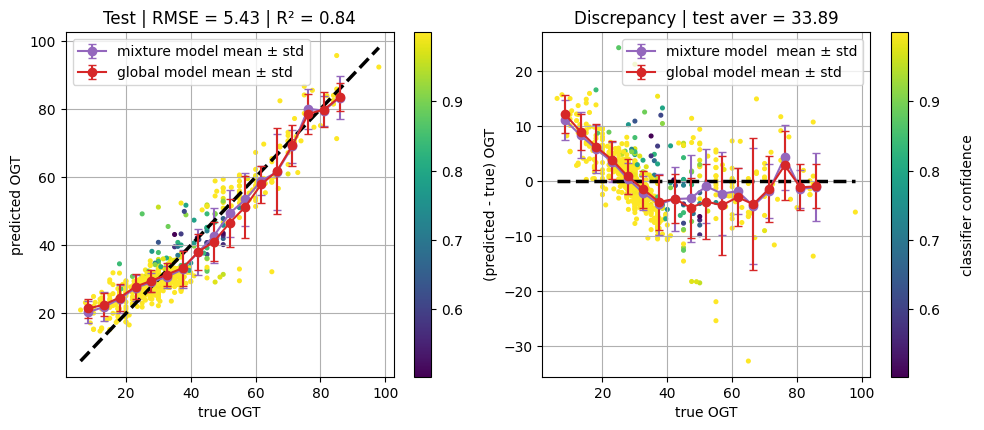

In [54]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


plt.figure(figsize=(10, 8))

y_test = y_test.cpu()
mx_prob = [max(g) for g in gate_probs]

num_bins = 20
min_temp = min(y_test.squeeze())
max_temp = max(y_test.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_test.cpu(), final_pred, marker='o', alpha = 1, c = mx_prob, s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), final_pred, num_bins)
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze(), final_pred))
r2_test = r2_score(y_test.squeeze(), final_pred)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:purple', capsize=3, label='mixture model mean ± std')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")

plt.errorbar(bin_centers_cv_old, mean_diff_cv_old, yerr=std_diff_cv_old, fmt='o-', color='tab:red', capsize=3, label='global model mean ± std')
plt.legend()
plt.grid(True)
cbar = plt.colorbar()

# Diff for full signal  
plt.subplot(2, 2, 2) 
y_test = y_test.cpu()
diff = [final_pred[i] - y_test[i] for i in range(len(final_pred))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 1, c = mx_prob, s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:purple', capsize=3, label='mixture model  mean ± std')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 

plt.errorbar(bin_centers_test_old, mean_diff_test_old, yerr=std_diff_test_old, fmt='o-', color='tab:red', capsize=3, label='global model mean ± std')

plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | test aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label("classifier confidence", rotation=90, labelpad=15)  # vertical title




# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/mixture_of_experts_2_class.pdf", format="pdf")
plt.show()

Top 20 important features:
K07146: 0.2254
K00031: 0.1162
K13633: 0.0493
K01246: 0.0294
K04487: 0.0284
K08097: 0.0208
K11530: 0.0193
K06416: 0.0167
K06974: 0.0151
K03856: 0.0138
K19091: 0.0137
K04758: 0.0126
K06922: 0.0125
K06390: 0.0113
K01834: 0.0092
K06158: 0.0079
K00177: 0.0076
K02348: 0.0070
K03595: 0.0067
K03321: 0.0064


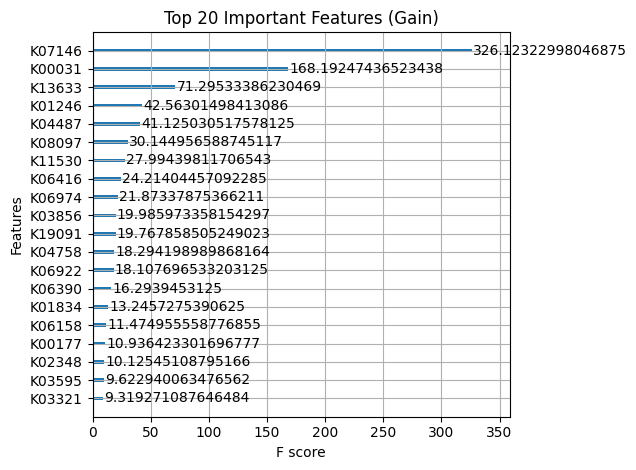

In [48]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importances from trained model
importances = gating_model.feature_importances_

# Use your actual column names
feature_names = X_column_names  # Make sure it's a list of strings

# Pair and sort
feature_importance_list = sorted(zip(feature_names, importances), key=lambda x: -x[1])

# Print top features
print("Top 20 important features:")
for feature, score in feature_importance_list[:20]:
    print(f"{feature}: {score:.4f}")

booster = gating_model.get_booster()

# Assign actual feature names
booster.feature_names = list(X_column_names)

# Plot
xgb.plot_importance(gating_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Important Features (Gain)")
plt.tight_layout()
plt.show()



Average counts for top 20 features by class:
         K07146    K00031    K13633    K01246    K04487    K08097    K11530  \
label                                                                         
0      0.659462  0.762235  1.421697  0.941272  1.579119  0.126835  1.448206   
1      0.107273  0.185455  0.161818  0.176364  1.300000  0.232727  0.250909   

         K06416    K06974    K03856    K19091    K04758    K06922    K06390  \
label                                                                         
0      0.101550  0.125612  0.220228  0.103589  0.672104  0.103589  0.081158   
1      0.672727  0.325455  0.814545  1.196364  1.060000  0.381818  0.414545   

         K01834    K06158    K00177    K02348    K03595    K03321  
label                                                              
0      0.532219  2.207586  0.123573  1.019576  1.171697  2.083197  
1      0.190909  0.772727  0.758182  0.387273  1.080000  0.527273  


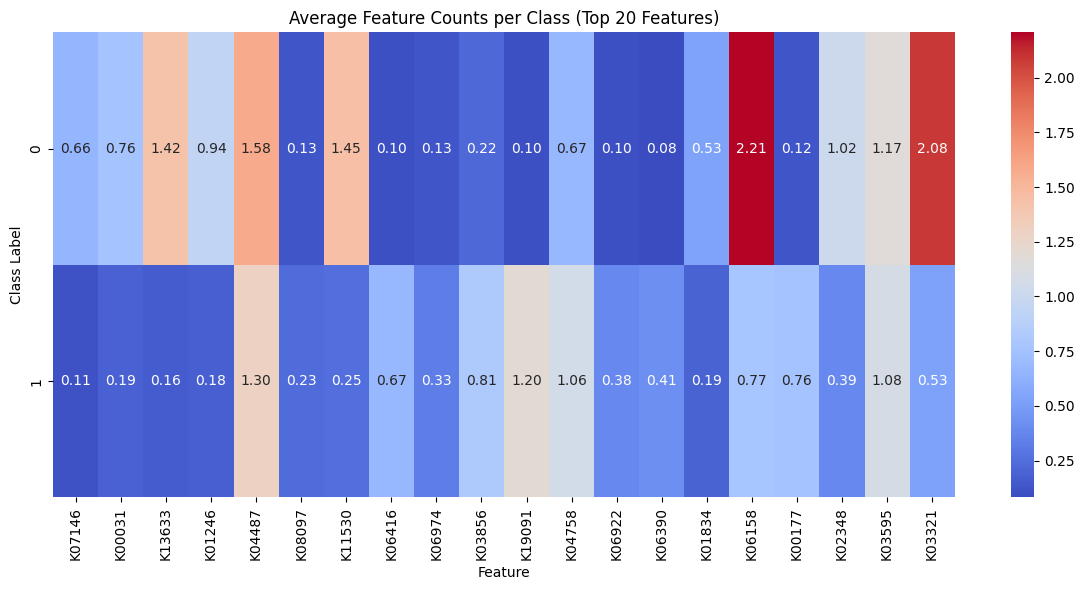

In [49]:
import numpy as np
import pandas as pd

# Convert to DataFrame for easier handling
df = pd.DataFrame(X_train.cpu(), columns=X_column_names)
df['label'] = range_ids

# Top 20 important features
top_features = [f for f, _ in feature_importance_list[:20]]

# Compute average counts for each class
grouped_means = df.groupby('label')[top_features].mean()

# Print results
print("\nAverage counts for top 20 features by class:")
print(grouped_means)

# Optional: visualize as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(grouped_means, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average Feature Counts per Class (Top 20 Features)")
plt.xlabel("Feature")
plt.ylabel("Class Label")
plt.tight_layout()
plt.show()


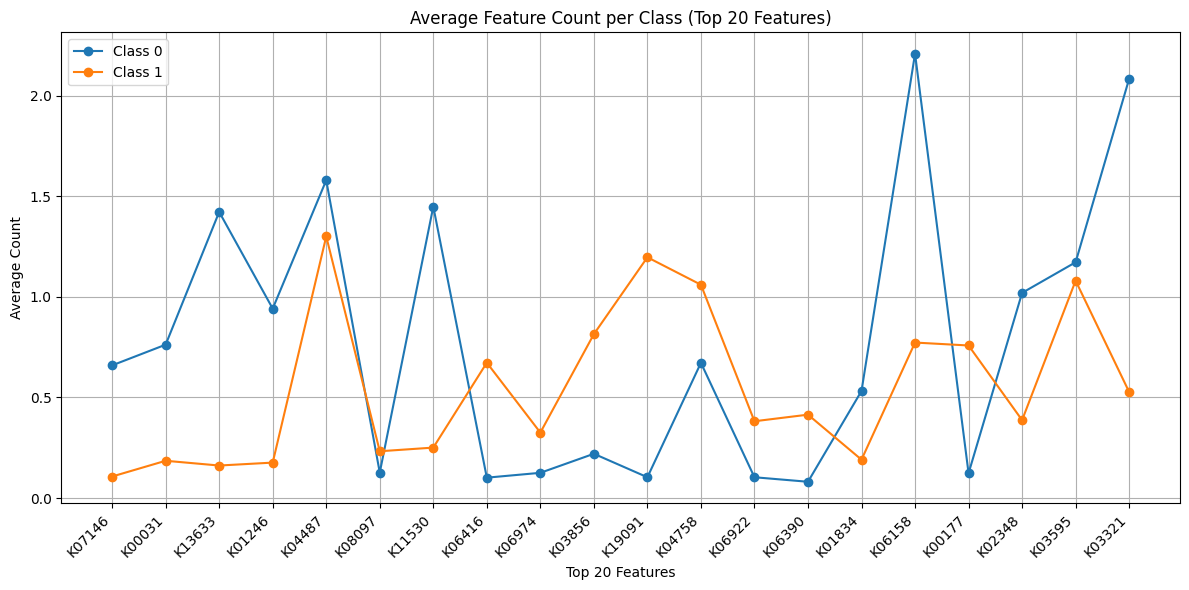

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame if not already
df = pd.DataFrame(X_train.cpu(), columns=X_column_names)
df['label'] = range_ids

# Get top 20 important features
top_features = [f for f, _ in feature_importance_list[:20]]

# Compute mean feature values per class
grouped_means = df.groupby('label')[top_features].mean()

# Plot lines for each class
plt.figure(figsize=(12, 6))

for class_label in grouped_means.index:
    plt.plot(top_features, grouped_means.loc[class_label], marker='o', label=f'Class {class_label}')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Top 20 Features")
plt.ylabel("Average Count")
plt.title("Average Feature Count per Class (Top 20 Features)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


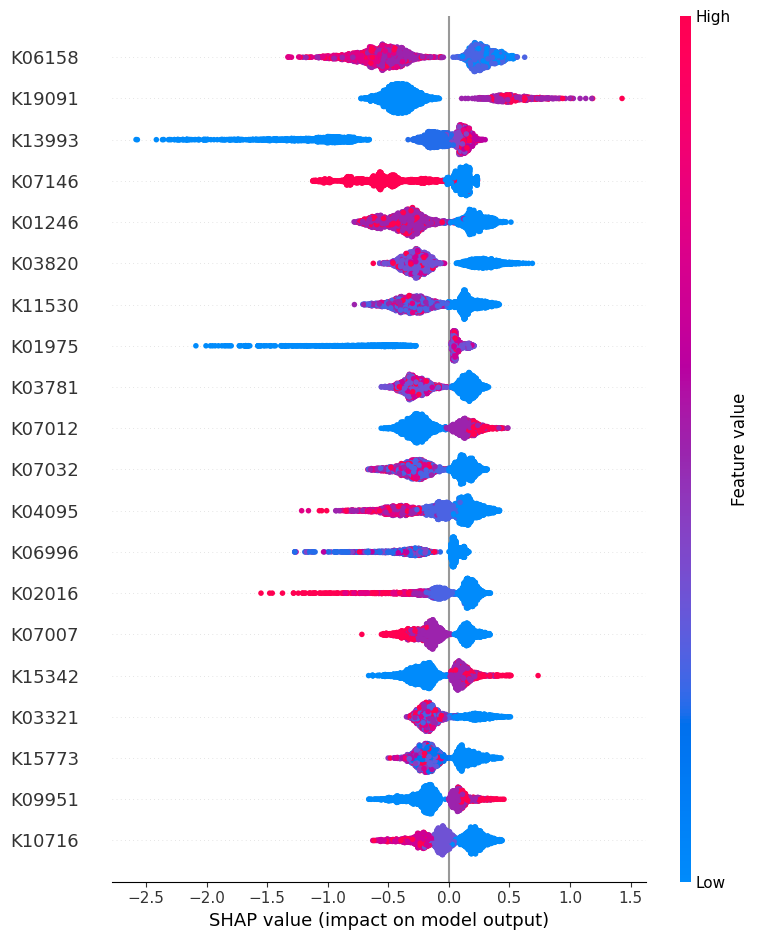

In [51]:
import pandas as pd
import shap

X_train = X_train.cpu()

# If X_train is a NumPy array, convert it:
X_train_df = pd.DataFrame(X_train, columns=X_column_names)

# Recompute SHAP values if needed
explainer = shap.TreeExplainer(gating_model)
shap_values = explainer.shap_values(X_train_df)

# If it's a binary classifier:
shap.summary_plot(shap_values, X_train_df)
